In [ ]:
import numpy
import tensorflow as tf
import autogluon as ag

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from features import triple_barrier as tb, getTA, tautil, microstructure_features as ms
import autogluon as ag

from sklearn import preprocessing
from sklearn.decomposition import PCA 
from features import triple_barrier as tb, getTA, tautil

from scipy.stats import norm, moment

import keras

import warnings
warnings.filterwarnings(action='ignore')

def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()
    
# df_raw = pd.read_csv('ethusd5min.csv')
# df = df_raw.set_index('timestamp')
# df.index = pd.to_datetime(df.index)

from dataload import data_load_v2

sym = 'ETHUSDT'
data_dir = '/Users/aming/data/ETHUSDT/15m'
start_date_train = '2025-01-01'
end_date_train = '2025-06-01'
start_date_test = '2025-06-01'
end_date_test = '2025-09-01'
timeframe =  '15m'


df = data_load_v2(sym, data_dir=data_dir, start_date=start_date_train, end_date=end_date_test,
                        timeframe=timeframe, file_path=None)

column_mapping = {
    'o':'open',
    'h':'high',
    'l':'low',
    'c':'close',
    'vol':'volume',
    'vol_ccy':'quote_av',
    'trades':'count',
    'close_time':'close_time',
    'taker_buy_volume':'tb_base_av',
    'taker_buy_quote_volume':'tb_quote_av'
}


df = df.rename(columns=column_mapping)

df = df.resample('1H').agg({'open':'first',
                            'high':'max',
                            'low':'min',
                            'close':'last',
                            'volume':'sum',
                            'quote_av':'sum',
                            'count':'sum',
                            'tb_base_av':'sum',
                            'tb_quote_av':'sum',
                            'close_time':'last'
                            })

close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

def get_hourly_vol(close, span0=100):
    """
    计算小时级波动率 (基于 EWM)
    
    Parameters
    ----------
    close : pd.Series
        小时级收盘价
    span0 : int
        EWM 的跨度 (span)。
        如果是小时数据，span=100 大约代表回顾过去 4 天 (100小时) 的波动情况。
    """
    # 1. 计算小时收益率 (r_t = p_t / p_{t-1} - 1)
    # 也就是当前小时相对于上一小时的涨跌幅
    returns = close.pct_change()
    
    # 2. 计算指数加权移动标准差
    vol = returns.ewm(span=span0).std()
    
    return vol

# ========================================
# 使用最佳参数重新计算barrier
# ========================================

# 选择要使用的最佳参数（可根据需要选择Sharpe最高或收益最高）
selected_params = {
    'vol_span': 24,
    'vol_span_days': 1,
    'cusum_multiplier': 1,
    'profit_taking': 2.5,
    'stop_loss': 0.5,
    'max_holding_hours': 48
}  # 或者 best_return

print("=" * 60)
print("使用最佳参数重新计算")
print("=" * 60)
print(f"波动率窗口: {selected_params['vol_span_days']:.1f}天 ({int(selected_params['vol_span'])}小时)")
print(f"CUSUM倍数: {selected_params['cusum_multiplier']}")
print(f"止盈倍数: {selected_params['profit_taking']}")
print(f"止损倍数: {selected_params['stop_loss']}")
print(f"最大持仓: {selected_params['max_holding_hours']}小时")
print("=" * 60)

# 使用最佳参数重新计算
hourly_vol = get_hourly_vol(close, span0=int(selected_params['vol_span']))

cusum_thresh = hourly_vol.mean() * selected_params['cusum_multiplier']
log_prices = np.log(close)
t_events = tb.cusum_filter(log_prices, threshold=cusum_thresh)

pt_sl = [selected_params['profit_taking'], selected_params['stop_loss']]
max_holding = [0, int(selected_params['max_holding_hours'])]

barrier = tb.get_barrier_fast(close, t_events, pt_sl, 
                               max_holding=max_holding, 
                               target=hourly_vol)

print(f"\n触发事件数: {len(t_events)}")
print(f"有效交易数: {len(barrier.dropna(subset=['exit']))}")
print(f"平均小时波动率: {hourly_vol.mean():.4%}")
print(f"CUSUM阈值: {cusum_thresh:.6f}")

# 绘制cumulative returns
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 累计收益曲线
cumret = barrier['ret'].cumsum()
axes[0].plot(cumret, linewidth=1.5, color='darkblue', label='累计对数收益')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].fill_between(cumret.index, cumret, 0, alpha=0.3, color='skyblue')
axes[0].set_title('最佳参数 - 累计收益曲线', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('累计对数收益')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 每次交易的收益
axes[1].bar(barrier.index, barrier['ret'], width=pd.Timedelta(hours=1), 
            color=['green' if x > 0 else 'red' for x in barrier['ret']], 
            alpha=0.6, edgecolor='black', linewidth=0.5)
axes[1].axhline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_title('最佳参数 - 单次交易收益分布', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('单次收益')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('best_params_performance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n图表已保存到: best_params_performance.png")

# 显示barrier数据
print(f"\nBarrier数据预览:")
barrier.head(10)


In [40]:
barrier

,exit,price,side,ret
2025-01-01 08:00:00,2025-01-01 10:00:00,3335.57,1.0,-0.002876
2025-01-01 15:00:00,2025-01-01 16:00:00,3352.07,1.0,-0.004284
2025-01-01 21:00:00,2025-01-01 22:00:00,3367.60,1.0,-0.002096
2025-01-02 00:00:00,2025-01-02 01:00:00,3389.12,1.0,-0.001804
2025-01-02 04:00:00,2025-01-02 06:00:00,3417.81,1.0,-0.002229
...,...,...,...,...
2025-09-30 09:00:00,2025-09-30 15:00:00,4139.25,1.0,-0.005125
2025-09-30 15:00:00,2025-09-30 16:00:00,4118.09,1.0,-0.004925
2025-09-30 19:00:00,2025-09-30 22:00:00,4158.48,1.0,-0.005017
2025-09-30 20:00:00,2025-09-30 21:00:00,4194.12,1.0,-0.010520


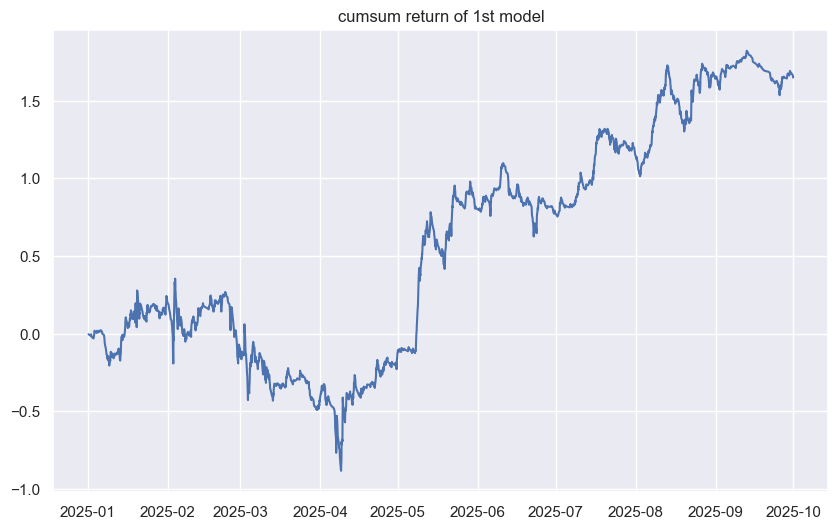

In [ ]:
ret = barrier.ret

plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

In [11]:
t_events

DatetimeIndex(['2025-01-01 08:00:00', '2025-01-01 15:00:00',
               '2025-01-01 21:00:00', '2025-01-02 00:00:00',
               '2025-01-02 04:00:00', '2025-01-02 08:00:00',
               '2025-01-02 09:00:00', '2025-01-02 14:00:00',
               '2025-01-02 15:00:00', '2025-01-02 22:00:00',
               ...
               '2025-09-29 13:00:00', '2025-09-29 16:00:00',
               '2025-09-29 19:00:00', '2025-09-29 20:00:00',
               '2025-09-30 04:00:00', '2025-09-30 09:00:00',
               '2025-09-30 15:00:00', '2025-09-30 19:00:00',
               '2025-09-30 20:00:00', '2025-09-30 21:00:00'],
              dtype='datetime64[ns]', length=2152, freq=None)

In [13]:
# df_enter = df.copy()

# df_enter['signal'] = df_enter.index.isin(t_events).astype(int)

# df_enter

event_series = pd.Series(0, index=df.index)


event_series.loc[df.index.isin(t_events)] = 1

event_series

open_time
2025-01-01 00:00:00    0
2025-01-01 01:00:00    0
2025-01-01 02:00:00    0
2025-01-01 03:00:00    0
2025-01-01 04:00:00    0
                      ..
2025-09-30 19:00:00    1
2025-09-30 20:00:00    1
2025-09-30 21:00:00    1
2025-09-30 22:00:00    0
2025-09-30 23:00:00    0
Freq: h, Length: 6552, dtype: int64

## Binary Labeling (Profit or Loss)

In [14]:
first_model = pd.DataFrame()
first_model['y_pred'] = event_series
first_model['y_true'] = np.sign(event_series*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

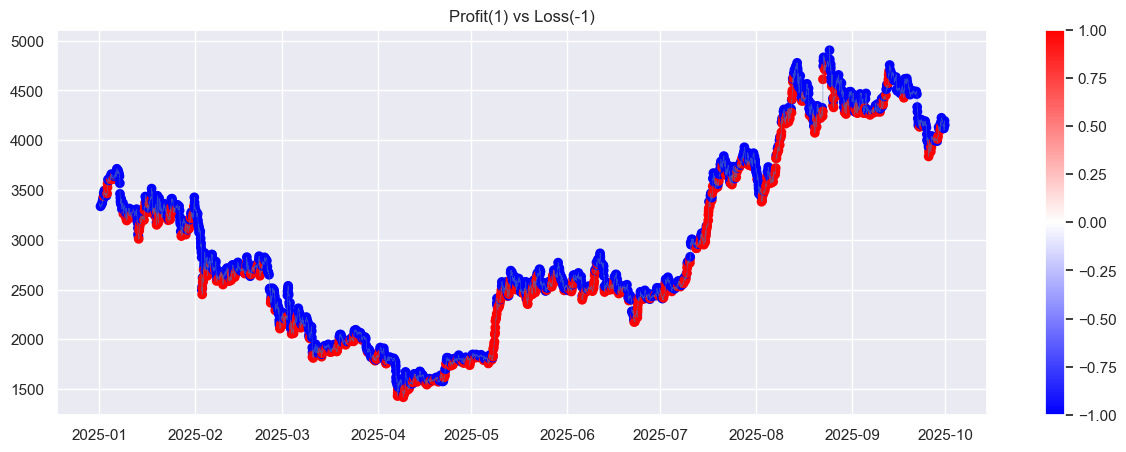

In [15]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [16]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

y_true
-1.0    1522
 1.0     630
Name: count, dtype: int64

In [20]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.7072490706319703


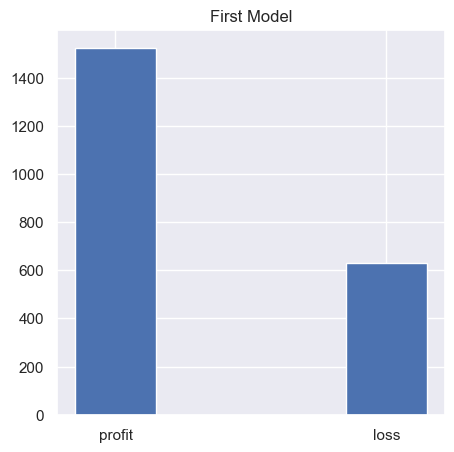

In [21]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

# Prediction Model

For feature engineering we have to split train and test periods.

In [22]:
y = pnllabel.copy().rename('y').to_frame()
train_y = y.loc[:end_date_train,:]
test_y = y.loc[start_date_test:,:]
y
train_y

,y
open_time,
2025-01-01 08:00:00,-1.0
2025-01-01 15:00:00,-1.0
2025-01-01 21:00:00,-1.0
2025-01-02 00:00:00,-1.0
2025-01-02 04:00:00,-1.0
...,...
2025-06-01 09:00:00,-1.0
2025-06-01 14:00:00,1.0
2025-06-01 16:00:00,-1.0


 ## Get Features (X)
 
 ###  Market data

Market
- Techincal indicators with market data


In [23]:
# df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ = df
of = buy_volume - (volume-buy_volume)
df_

,open,high,low,close,volume,quote_av,count,tb_base_av,tb_quote_av,close_time
open_time,,,,,,,,,,
2025-01-01 00:00:00,3336.58,3364.50,3334.76,3362.90,68327.229,2.290786e+08,128259,41887.238,1.404357e+08,1735693199999
2025-01-01 01:00:00,3362.89,3365.32,3341.18,3345.82,40083.238,1.344243e+08,96672,18969.926,6.361368e+07,1735696799999
2025-01-01 02:00:00,3345.83,3368.02,3345.25,3361.81,41313.759,1.387134e+08,89727,23341.983,7.836713e+07,1735700399999
2025-01-01 03:00:00,3361.81,3363.00,3350.23,3354.34,24803.739,8.324149e+07,65599,13395.447,4.495619e+07,1735703999999
2025-01-01 04:00:00,3354.35,3355.77,3338.26,3339.94,54111.924,1.810773e+08,79342,24044.915,8.046846e+07,1735707599999
...,...,...,...,...,...,...,...,...,...,...
2025-09-30 19:00:00,4114.88,4170.00,4106.81,4158.48,216375.675,8.953288e+08,247216,128981.216,5.337550e+08,1759262399999
2025-09-30 20:00:00,4158.48,4196.00,4146.66,4194.12,171788.368,7.165371e+08,219952,92056.822,3.840734e+08,1759265999999
2025-09-30 21:00:00,4194.12,4199.89,4149.76,4150.23,186061.569,7.767539e+08,197845,67277.871,2.809791e+08,1759269599999


In [24]:
mts= [5,10,30,60,100] #multipliers
TA = getTA.get_ta_windows(df_,mts)

In [25]:
TA

,aroon_125,aroon_1500,aroon_250,aroon_2500,aroon_750,dpo_100,dpo_1200,dpo_200,dpo_2000,dpo_600,...,rsi_140,rsi_1400,rsi_420,rsi_70,rsi_840,stoch_diff_1400_3,stoch_diff_140_3,stoch_diff_420_3,stoch_diff_70_3,stoch_diff_840_3
open_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 19:00:00,82.4,34.8,-48.4,60.4,-40.266667,-45.1622,-84.762917,-153.60700,70.246315,236.037317,...,49.550104,50.883311,49.194393,52.347277,50.311908,2.271499,8.045598,3.730461,12.046141,3.613460
2025-09-30 20:00:00,82.4,34.8,-48.4,60.4,-40.266667,-41.0601,-66.143600,-138.84580,73.478755,240.034183,...,50.430190,50.961332,49.465946,54.027817,50.439303,2.544389,9.012168,4.178626,13.493322,4.047569
2025-09-30 21:00:00,82.4,34.8,-48.4,60.4,-40.266667,-39.4198,-58.817125,-94.66180,101.840440,266.834650,...,49.362120,50.861765,49.141713,51.747841,50.280359,-1.154909,-4.090663,-1.896697,-6.124678,-1.837209


First I chose default windows (daily) for each technical indicators/

This is 5 minute data and in first model, I chose rsi_100 instead of rsi_14.

So I will muliply some numbers to the windows. [10,30,50,100]

In [26]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'quote_av', 'count',
       'tb_base_av', 'tb_quote_av', 'close_time'],
      dtype='object')

In [27]:
mkt = TA.copy()

for i in [1,5,10,30]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,30,60,100]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))

for i in [5,10,30]:
    ms_features = ms.get_microstructure_features(df, window=i)
    # print(ms_features.isna().mean().sort_values(ascending=False).head(20))
    mkt = mkt.join(ms_features)

for i in [5,30,60,100]:
    stationary_features = tautil.get_stationary_ta_window_0(df, mt=i, fillna=True)
    mkt = mkt.join(stationary_features)

# mkt = mkt.dropna()
mkt

corr = mkt.corr()
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [28]:
mkt

,aroon_125,aroon_1500,aroon_250,aroon_2500,aroon_750,dpo_100,dpo_1200,dpo_200,dpo_2000,dpo_600,...,momentum_rsi_1500,momentum_tsi_2500_1500,momentum_stoch_1500,momentum_stoch_signal_1500,momentum_wr_1500,momentum_ao_500_3500,momentum_roc_1000,momentum_ppo_2500_1000_9,momentum_ppo_signal_2500_1000_9,momentum_ppo_hist_2500_1000_9
open_time,,,,,,,,,,,,,,,,,,,,,
2025-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,0.000000,94.620040,94.620040,-5.379960,0.000000,0.000000,0.000000,0.000000,0.000000
2025-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,-100.000000,36.191099,65.405570,-63.808901,0.000000,0.000000,-0.000609,-0.000122,-0.000487
2025-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.368635,-99.999800,81.328924,70.713354,-18.671076,0.000000,0.000000,-0.000646,-0.000227,-0.000419
2025-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.448757,-99.999601,58.869513,58.796512,-41.130487,0.000000,0.000000,-0.000949,-0.000371,-0.000578
2025-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,29.097690,-99.999403,15.574263,51.924233,-84.425737,0.000000,0.000000,-0.001764,-0.000650,-0.001115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-30 19:00:00,82.4,34.8,-48.4,60.4,-40.266667,-45.1622,-84.762917,-153.60700,70.246315,236.037317,...,50.927468,2.202876,50.180157,48.049239,-49.819843,937.535071,0.470645,10.618855,10.669508,-0.050653
2025-09-30 20:00:00,82.4,34.8,-48.4,60.4,-40.266667,-41.0601,-66.143600,-138.84580,73.478755,240.034183,...,51.000855,2.201502,52.401880,50.014961,-47.598120,936.608861,0.624024,10.607994,10.657205,-0.049211
2025-09-30 21:00:00,82.4,34.8,-48.4,60.4,-40.266667,-39.4198,-58.817125,-94.66180,101.840440,266.834650,...,50.907039,2.199832,49.665869,50.749302,-50.334131,935.691196,-0.735711,10.595874,10.644939,-0.049065


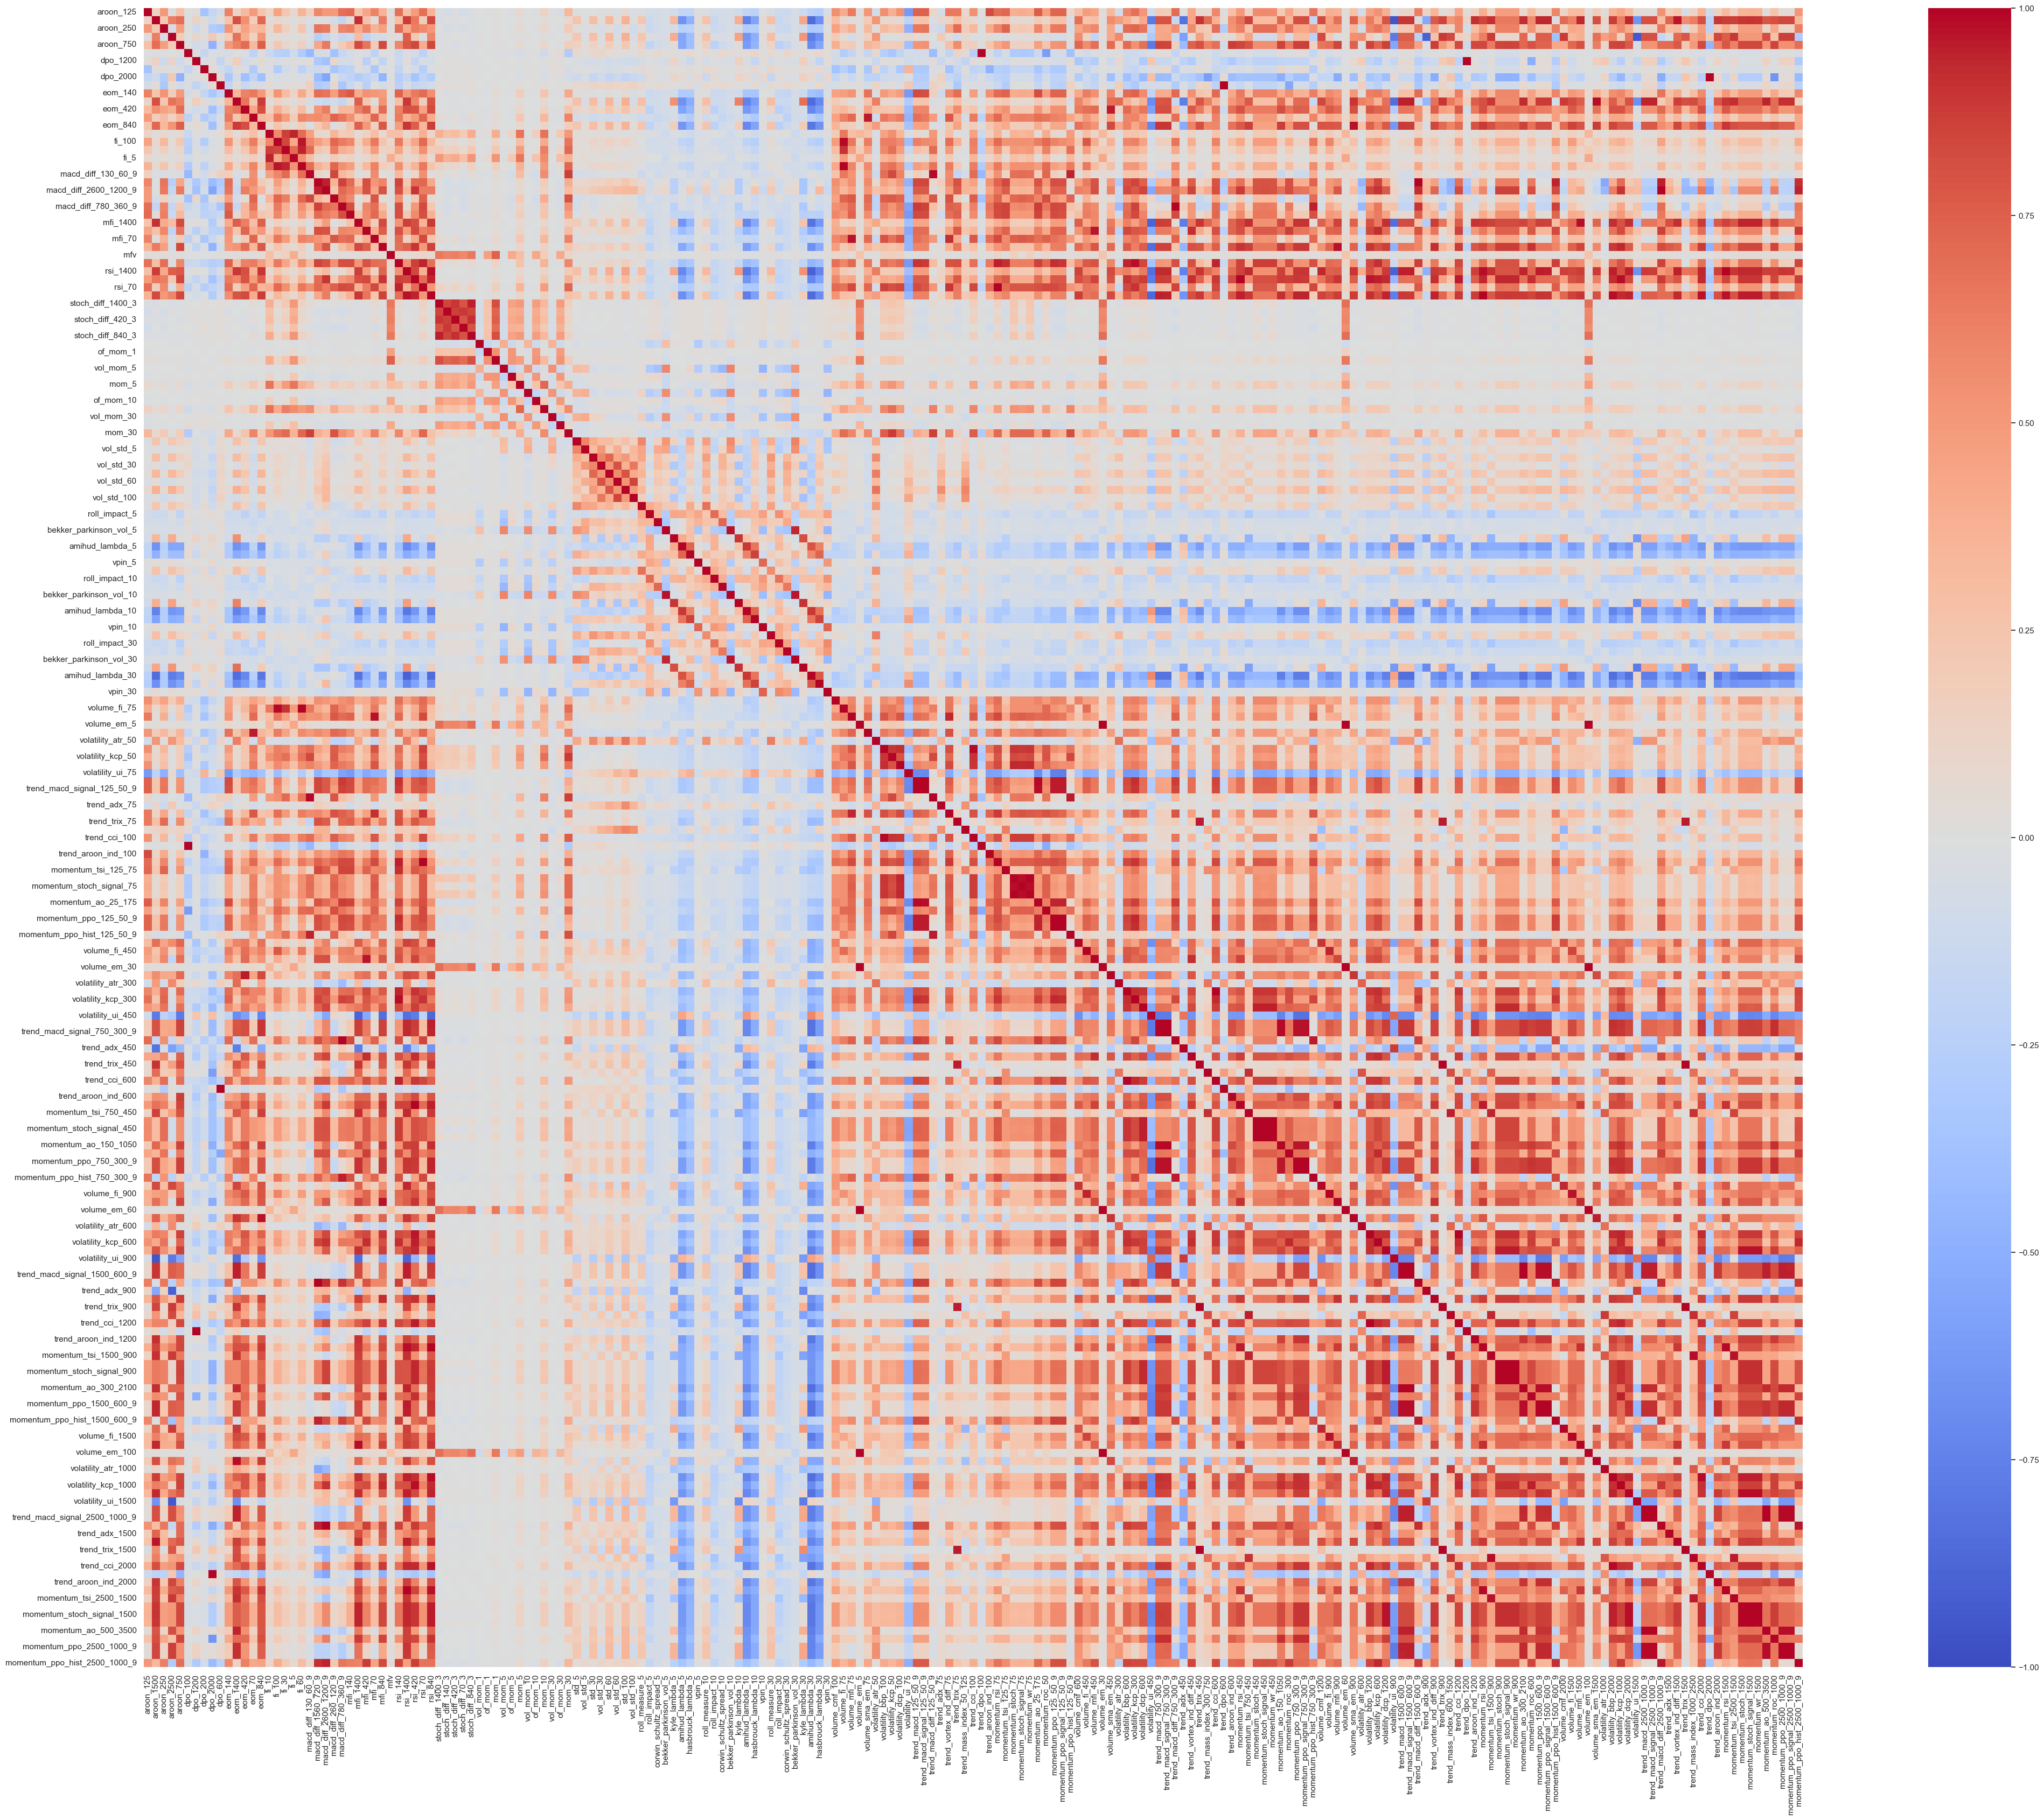

In [29]:
plt.figure(figsize=(60,40))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1, square=True)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [30]:
# Highly correlated market features

h = 0.75
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))[::2,:]
hc_list


array([['amihud_lambda_10', 'amihud_lambda_30'],
       ['amihud_lambda_10', 'amihud_lambda_5'],
       ['amihud_lambda_10', 'rsi_1400'],
       ...,
       ['volume_sma_em_1500', 'volume_sma_em_450'],
       ['volume_sma_em_1500', 'volume_sma_em_900'],
       ['volume_sma_em_450', 'volume_sma_em_900']], dtype='<U31')

In [31]:
drop_features = np.unique(hc_list[:,1])
drop_features

array(['amihud_lambda_30', 'amihud_lambda_5', 'aroon_1500', 'aroon_2500',
       'bekker_parkinson_vol_30', 'bekker_parkinson_vol_5', 'eom_1400',
       'eom_840', 'fi_30', 'fi_5', 'fi_60', 'hasbrouck_lambda_30',
       'hasbrouck_lambda_5', 'kyle_lambda_30', 'kyle_lambda_5',
       'macd_diff_2600_1200_9', 'macd_diff_260_120_9',
       'macd_diff_780_360_9', 'mfi_140', 'mfi_1400', 'mfi_420', 'mfi_70',
       'mfi_840', 'mom_30', 'momentum_ao_150_1050', 'momentum_ao_25_175',
       'momentum_ao_300_2100', 'momentum_ao_500_3500',
       'momentum_ppo_125_50_9', 'momentum_ppo_1500_600_9',
       'momentum_ppo_2500_1000_9', 'momentum_ppo_750_300_9',
       'momentum_ppo_hist_125_50_9', 'momentum_ppo_hist_1500_600_9',
       'momentum_ppo_hist_2500_1000_9', 'momentum_ppo_hist_750_300_9',
       'momentum_ppo_signal_125_50_9', 'momentum_ppo_signal_1500_600_9',
       'momentum_ppo_signal_2500_1000_9', 'momentum_ppo_signal_750_300_9',
       'momentum_roc_1000', 'momentum_roc_300', 'momentum

In [32]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

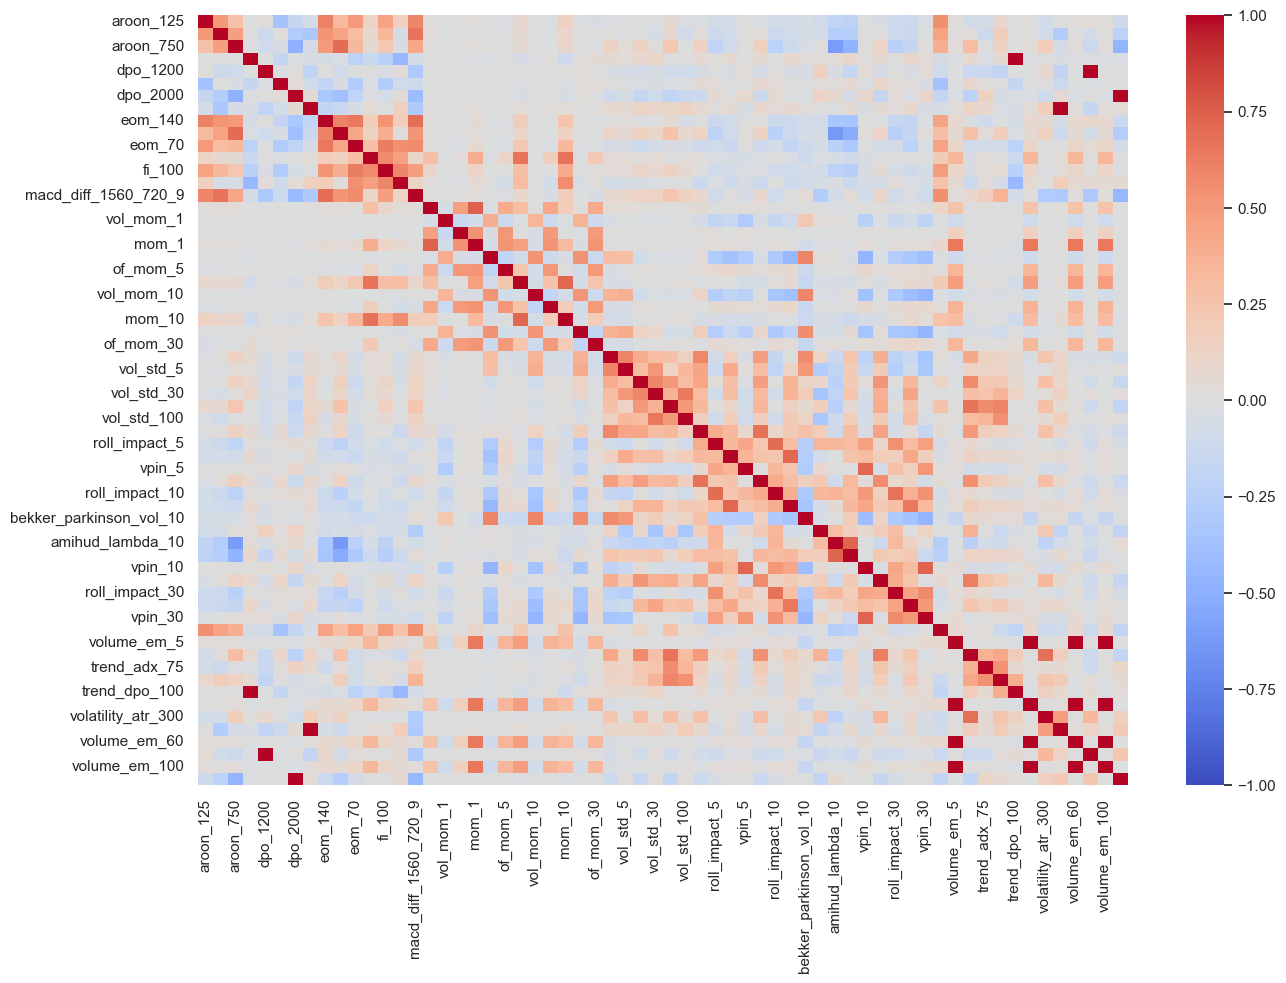

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

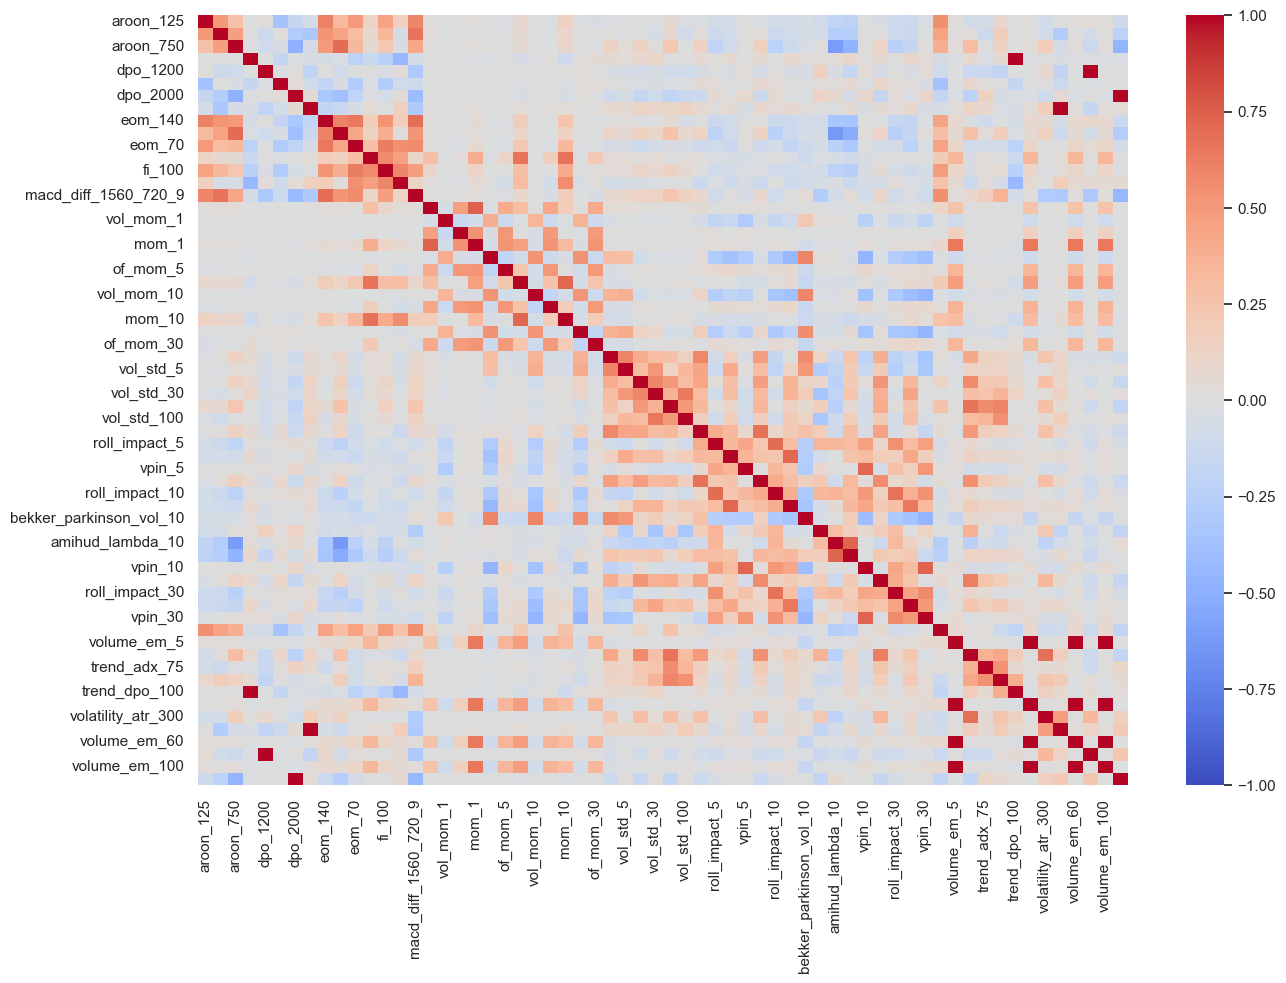

In [34]:
corr2 = mkt1.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

In [125]:
# ### Market Microstructures
# # 使用新添加的便捷函数生成微观结构特征
# ms_features = ms.get_microstructure_features(df, window=20)

# # 将其加入到主特征矩阵 mkt1 中
# mkt1 = mkt1.join(ms_features)

# # 检查一下生成的结果
# ms_features.tail()

### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

### Sentiments

We can get features from Natural Language Process.

Working on this.

In [35]:
raw_X = mkt1.shift(1).copy()

In [127]:
# for i in raw_X.columns:
#     plt.figure(figsize=(8,1))
#     plt.plot(raw_X[i])
#     plt.legend([i])

## Feature Engineering

### Feature Scaling

Do it train, test data seperately.
I fit the scaler only on the training dataset and then transform the test set.

*Due to computational cost (in autoencoders), I did scaling and dimension-reduction of index of meta-labels'.*


MINMAX

In [36]:
y = pnllabel.copy().rename('y').to_frame()
train_index = y.loc[:end_date_train]
test_index = y.loc[start_date_test:]

In [37]:
train_index.index
# raw_X

DatetimeIndex(['2025-01-01 08:00:00', '2025-01-01 15:00:00',
               '2025-01-01 21:00:00', '2025-01-02 00:00:00',
               '2025-01-02 04:00:00', '2025-01-02 08:00:00',
               '2025-01-02 09:00:00', '2025-01-02 14:00:00',
               '2025-01-02 15:00:00', '2025-01-02 22:00:00',
               ...
               '2025-05-30 22:00:00', '2025-05-31 01:00:00',
               '2025-05-31 03:00:00', '2025-05-31 12:00:00',
               '2025-06-01 01:00:00', '2025-06-01 09:00:00',
               '2025-06-01 14:00:00', '2025-06-01 16:00:00',
               '2025-06-01 18:00:00', '2025-06-01 21:00:00'],
              dtype='datetime64[ns]', name='open_time', length=1295, freq=None)

In [38]:
raw_X_train = raw_X.loc[train_index.index].dropna()
raw_X_test = raw_X.loc[test_index.index].dropna()

In [39]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X_train)

scaled_X_train = pd.DataFrame(scaler.transform(raw_X_train),index=raw_X_train.index,columns=raw_X.columns)
scaled_X_test = pd.DataFrame(scaler.transform(raw_X_test),index=raw_X_test.index,columns=raw_X.columns)

### Dimension Reduction
- PCA - linear
- Deep Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

https://github.com/jo-cho/ML_Finance_Codes/blob/master/Chapter8-Advanced-NNs/ML_in_Finance-RNNs-Bitcoin.ipynb

In [40]:
# PCA
n=5

pca = PCA(n)
pca.fit(scaled_X_train)

pca_X_train = pd.DataFrame(pca.transform(scaled_X_train),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_train.index)

pca_X_test = pd.DataFrame(pca.transform(scaled_X_test),columns = ['pc_{}'.format(i) for i in range(n)], index=scaled_X_test.index)

In [41]:
components_ = pca.components_

In [42]:
loadings = pd.DataFrame(components_, index = pca_X_train.columns, columns=mkt1.columns).T

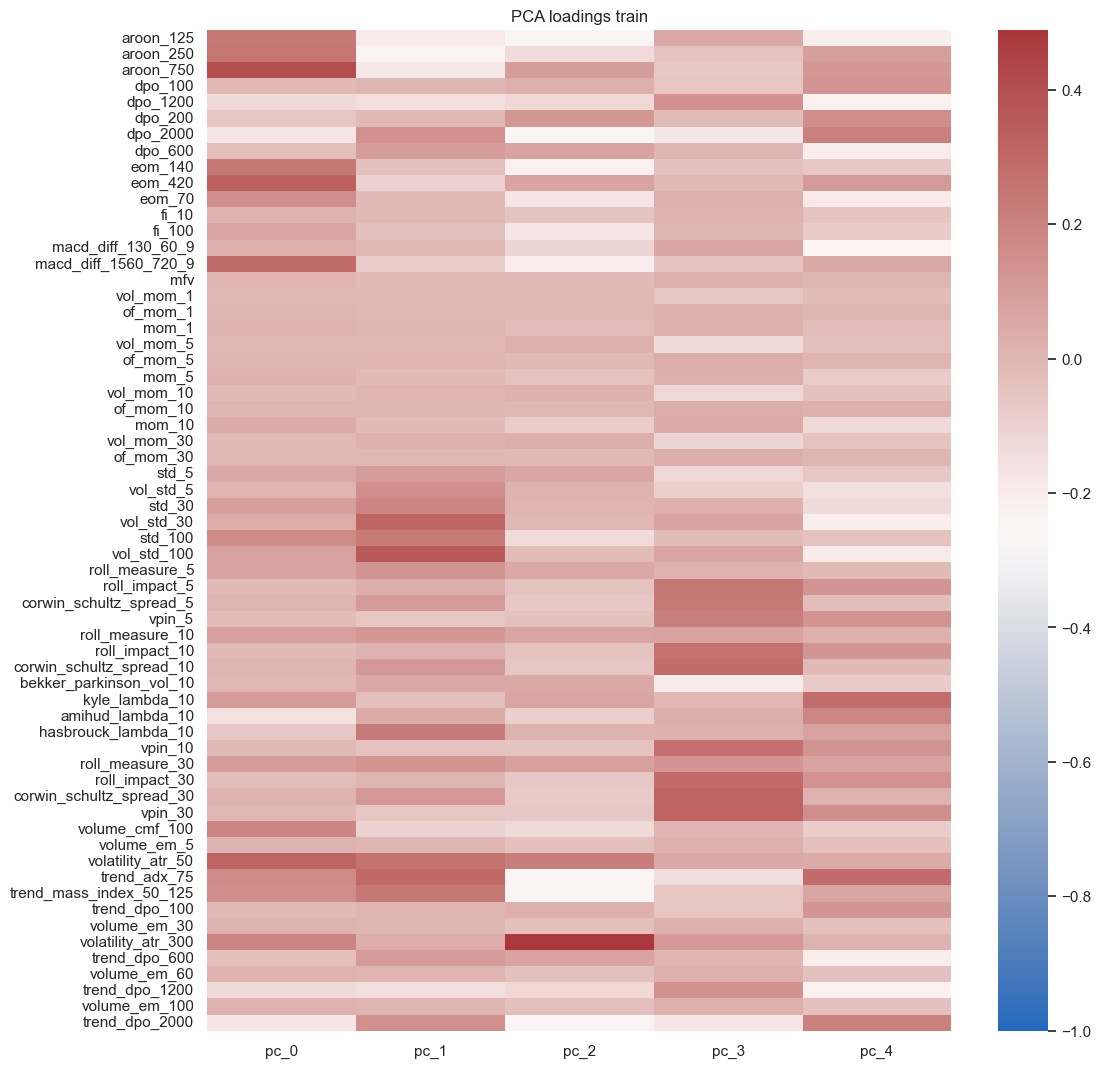

In [43]:
f = plt.figure(figsize=(12, 13))
sns.heatmap(loadings,cmap='vlag',vmin=-1)
plt.title('PCA loadings train')
plt.savefig('image/pcaloadings.jpg')
plt.show();

**Deep Autoencoders**

Non-Linear stacked autoencoders

https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743

In [44]:
x = scaled_X_train.copy()

epochs=100
dimension=5

In [45]:
keras.backend.clear_session()

In [46]:
nl_encoder = keras.models.Sequential([
    keras.layers.Dense(20, input_shape=[x.shape[1]], activation='relu'),
    keras.layers.Dense(15, activation='selu'),
    keras.layers.Dense(dimension, activation='selu'),
])

nl_decoder = keras.models.Sequential([
    keras.layers.Dense(15, input_shape=[dimension], activation='selu'),
    keras.layers.Dense(20, activation='selu'),
    keras.layers.Dense(x.shape[1], activation='relu'),
])

nl_autoencoder = keras.models.Sequential([nl_encoder, nl_decoder])
nl_autoencoder.compile(loss='mse', optimizer = keras.optimizers.SGD(learning_rate=0.1))
nl_autoencoder.summary()


history = nl_autoencoder.fit(x,x, epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(monitor='loss',patience=10)],
                             verbose=1)

2026-01-24 15:36:00.143857: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2026-01-24 15:36:00.144208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-24 15:36:00.144226: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-01-24 15:36:00.144305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-24 15:36:00.144734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 5)              │         1,655 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 62)             │         1,712 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,367 (13.15 KB)

 Trainable params: 3,367 (13.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2026-01-24 15:36:00.638483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4333
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3889
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3838
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3872
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3930
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3988
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4004
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4041
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4073
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4118
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4170
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4206
Epoch 13/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4252


In [47]:
encoded_X_train = nl_encoder.predict(scaled_X_train)
encoded_X_train = pd.DataFrame(encoded_X_train, index=scaled_X_train.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

encoded_X_test = nl_encoder.predict(scaled_X_test)
encoded_X_test = pd.DataFrame(encoded_X_test, index=scaled_X_test.index,columns=['encoded_{}'.format(i) for i in range(dimension)])

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [48]:
encoded_X_train

,encoded_0,encoded_1,encoded_2,encoded_3,encoded_4
open_time,,,,,
2025-03-25 08:00:00,0.250515,-0.871267,-0.231541,0.643010,-1.487103
2025-03-25 14:00:00,0.290902,-0.795290,-0.377061,0.509325,-1.418032
2025-03-26 02:00:00,0.284508,-0.718973,-0.280037,0.564266,-1.462711
2025-03-26 06:00:00,0.262087,-0.757930,-0.259570,0.575840,-1.442830
2025-03-26 13:00:00,0.273028,-0.852028,-0.104505,0.592059,-1.454879
...,...,...,...,...,...
2025-06-01 09:00:00,0.258593,-0.899928,0.220870,0.936317,-1.366744
2025-06-01 14:00:00,0.317367,-0.902744,0.049919,0.996695,-1.340432
2025-06-01 16:00:00,0.298876,-0.908828,0.051357,1.005928,-1.367859


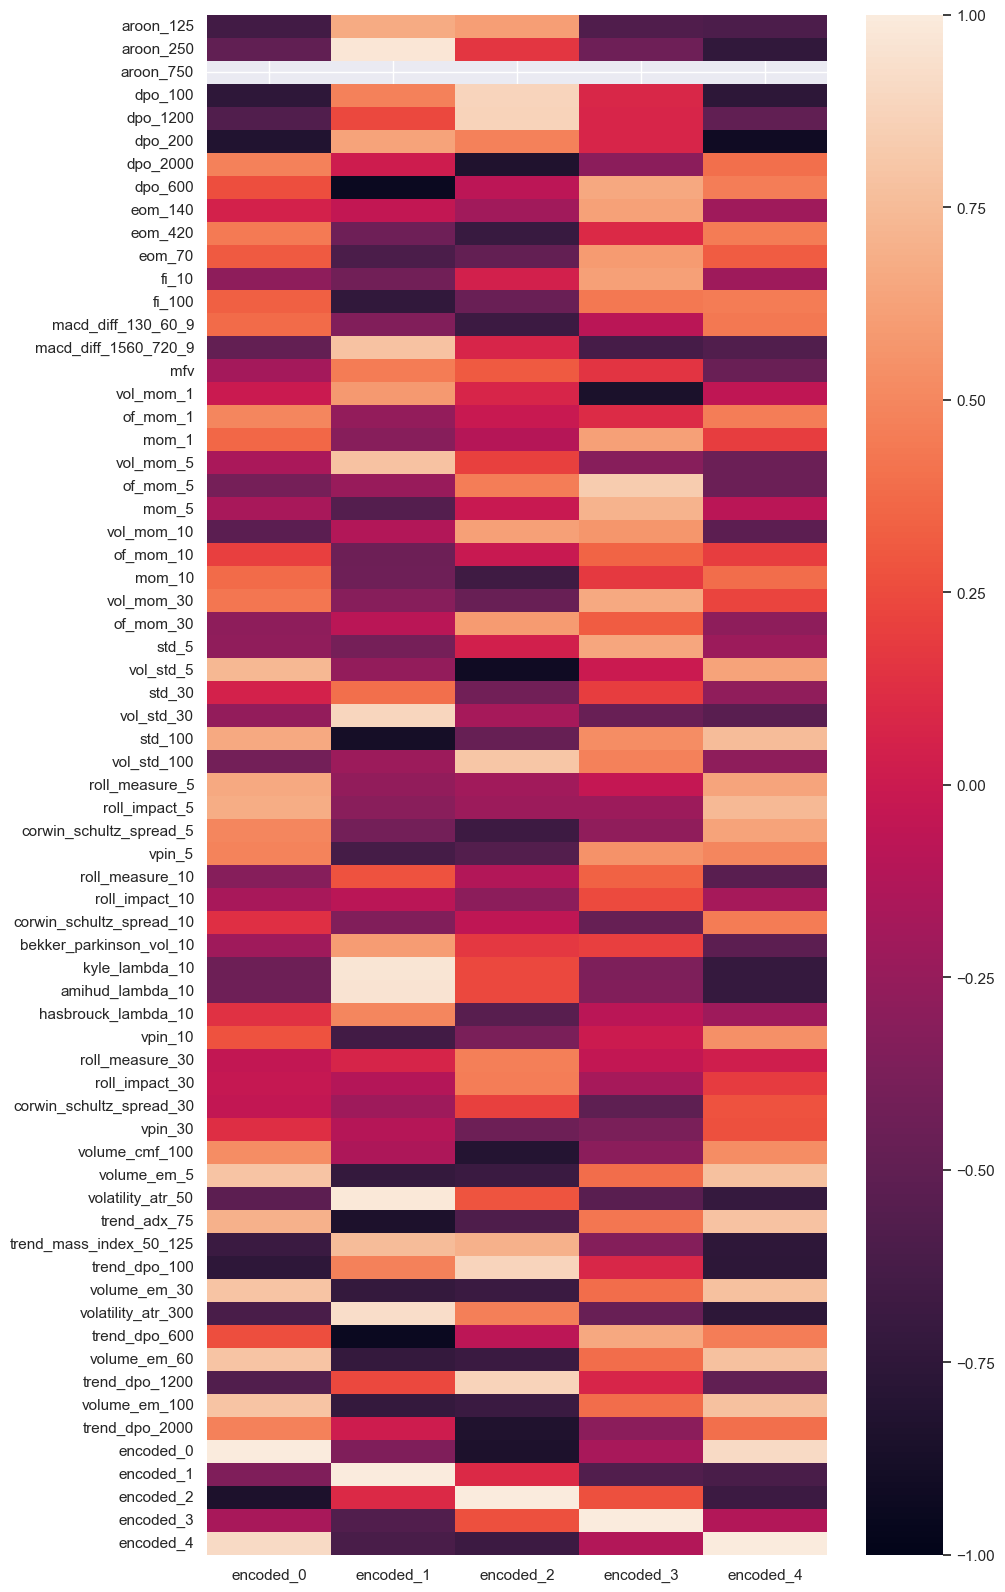

In [49]:
corr_encoded = scaled_X_test.join(encoded_X_train).corr().iloc[-5:].T

plt.figure(figsize=(10,20))
sns.heatmap(corr_encoded,vmin=-1,vmax=1)
plt.show()

COMPARE PCA and Non-linear autoencoder

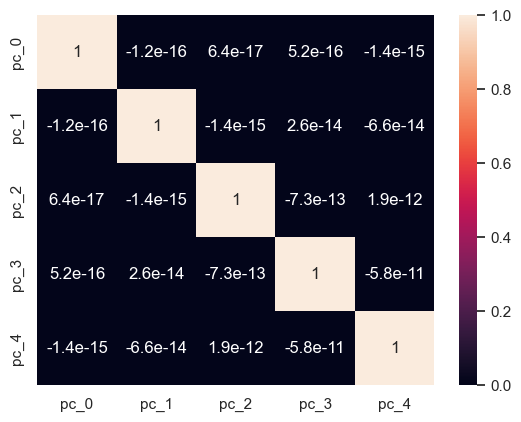

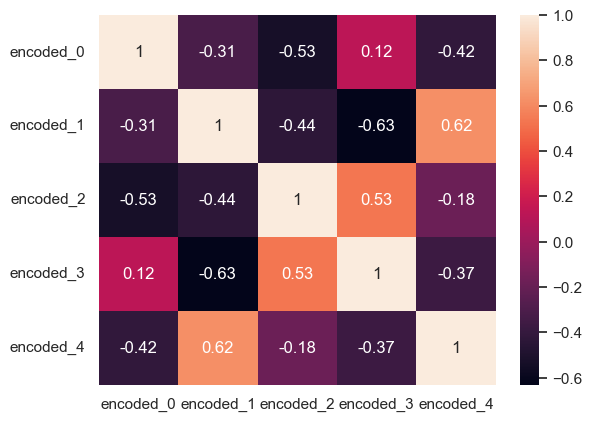

In [50]:
# correlation (linearly)
sns.heatmap(pca_X_train.corr(),annot=True)
plt.show()

sns.heatmap(encoded_X_train.corr(),annot=True)
plt.show()

# Machine Learning Model

## Hyper parameter tuning

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, it helps.

or F1 socre in general(*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. 
- Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [51]:
train_X = pca_X_train.copy() 
# or
#train_X= encoded_X_train.copy()

test_X = pca_X_test.copy()
# or
#test_X= encoded_X_test.copy()<Increasing p (probability of winning)>

FYI using encoded_X, the best precision score of auto ML models is around 0.66

In [52]:
train_data = train_X.join(train_y).dropna()
test_data = test_X.join(test_y).dropna()

## AutoML with autogluon and select the best model

In [53]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**(in symmetric barrier) or **f1 score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

And also it does CV, but not Purged K-Fold which was suggested by De Prado

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

In [54]:
predictor = TabularPredictor(label='y', eval_metric='precision').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20260124_073604"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.10.19
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Wed Jul  5 22:17:35 PDT 2023; root:xnu-8796.141.3~6/RELEASE_ARM64_T8112
CPU Count:          8
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
Memory Avail:       3.05 GB / 16.00 GB (19.1%)
Disk Space Avail:   128.36 GB / 460.43 GB (27.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for tabular data. Massively better than 'best' on datasets <100000 samples by using new Tabula

limitation
- shuffle 
- not good cv for finance data

In [55]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,0.500000,1.000000,precision,0.000898,0.000608,3.319579,0.000898,0.000608,3.319579,1,True,11
1,XGBoost,0.375839,0.529412,precision,0.003660,0.000933,0.616972,0.003660,0.000933,0.616972,1,True,9
2,LightGBMXT,0.375000,1.000000,precision,0.001574,0.000454,0.926450,0.001574,0.000454,0.926450,1,True,1
3,WeightedEnsemble_L2,0.375000,1.000000,precision,0.002191,0.001453,1.036771,0.000617,0.000999,0.110321,2,True,12
4,CatBoost,0.343750,0.800000,precision,0.001880,0.000511,0.914490,0.001880,0.000511,0.914490,1,True,5
5,NeuralNetTorch,0.337423,0.520000,precision,0.003261,0.001355,1.646279,0.003261,0.001355,1.646279,1,True,10
6,ExtraTreesGini,0.336735,0.571429,precision,0.033238,0.026998,0.212605,0.033238,0.026998,0.212605,1,True,6
7,ExtraTreesEntr,0.323529,0.578947,precision,0.033993,0.026427,0.224769,0.033993,0.026427,0.224769,1,True,7
8,RandomForestGini,0.312925,0.555556,precision,0.028260,0.027427,0.628363,0.028260,0.027427,0.628363,1,True,3
9,RandomForestEntr,0.303030,0.529412,precision,0.032671,0.026953,0.222326,0.032671,0.026953,0.222326,1,True,4


In [56]:
best_model = result.model[0]

In [57]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print(best_model, "'s predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

LightGBMLarge 's predictions:  
 open_time
2025-06-01 01:00:00   -1.0
2025-06-01 09:00:00   -1.0
2025-06-01 14:00:00    1.0
2025-06-01 16:00:00   -1.0
2025-06-01 18:00:00   -1.0
                      ... 
2025-09-30 09:00:00   -1.0
2025-09-30 15:00:00   -1.0
2025-09-30 19:00:00   -1.0
2025-09-30 20:00:00   -1.0
2025-09-30 21:00:00   -1.0
Name: y, Length: 863, dtype: float64


## Feature Importance

In autogluon,

- A feature's importance score represents the performance drop that results when the model makes predictions on a perturbed copy of the data where this feature's values have been randomly shuffled across rows.
- A feature score of 0.01 would indicate that the predictive performance dropped by 0.01 when the feature was randomly shuffled.
- The higher the score a feature has, the more important it is to the model's performance.
- If a feature has a negative score, this means that the feature is likely harmful to the final model, and a model trained with the feature removed would be expected to achieve a better predictive performance.

In [58]:
for i in result.model:
    print(i, "'s Feature Importance")
    fi = predictor.feature_importance(test_data, model=i, silent=True)
    print(fi)
    print('\n')

LightGBMLarge 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_2    0.256860  0.071767  0.000661  5  0.404630  0.109090
pc_1    0.150667  0.088658  0.009552  5  0.333215 -0.031881
pc_4    0.145034  0.114922  0.023866  5  0.381659 -0.091592
pc_0    0.067467  0.035924  0.006851  5  0.141436 -0.006502
pc_3    0.006041  0.061587  0.418570  5  0.132849 -0.120768


XGBoost 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_0    0.072880  0.016084  0.000267  5  0.105998  0.039762
pc_1    0.061600  0.022538  0.001814  5  0.108005  0.015194
pc_2    0.045674  0.029435  0.012795  5  0.106280 -0.014933
pc_4    0.044493  0.016416  0.001871  5  0.078293  0.010692
pc_3    0.001174  0.020471  0.452088  5  0.043323 -0.040975


LightGBMXT 's Feature Importance
      importance    stddev   p_value  n  p99_high   p99_low
pc_2    0.135725  0.079541  0.009425  5  0.299501 -0.028050
pc_4    0.041738  0.059593  0.096193  5  0.164442 -0.0809

## Results with PnL

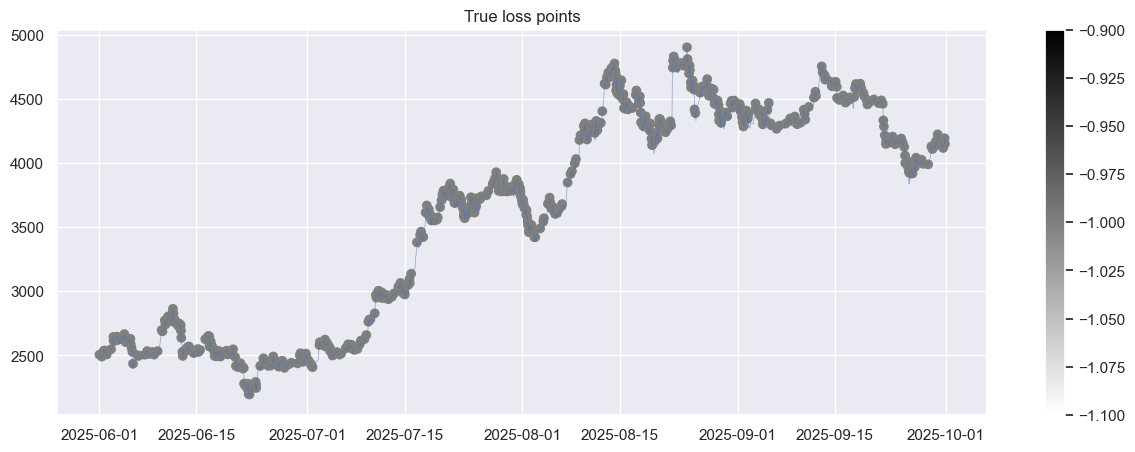

In [59]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

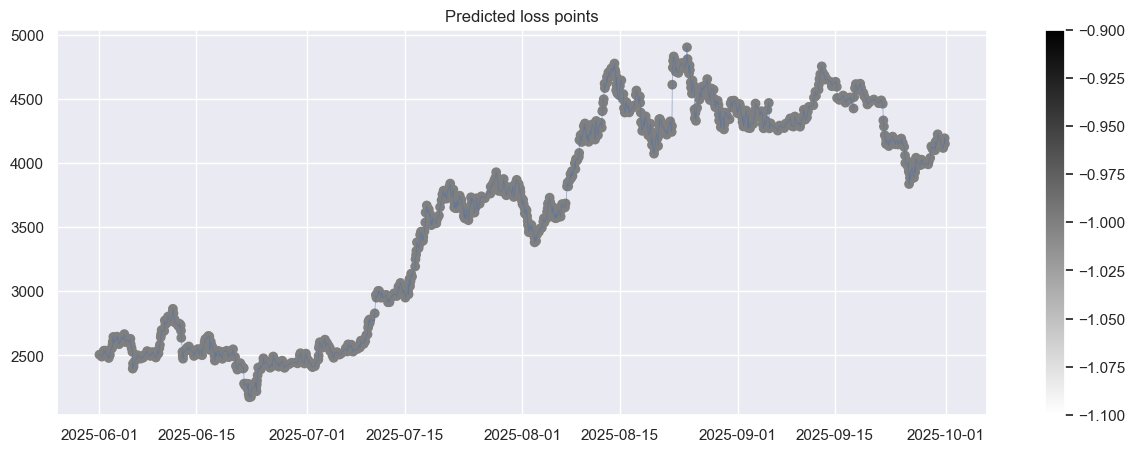

In [60]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [61]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

y
 1.0    9
-1.0    9
Name: count, dtype: int64

In [62]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())

이익확률 pi:  0.5


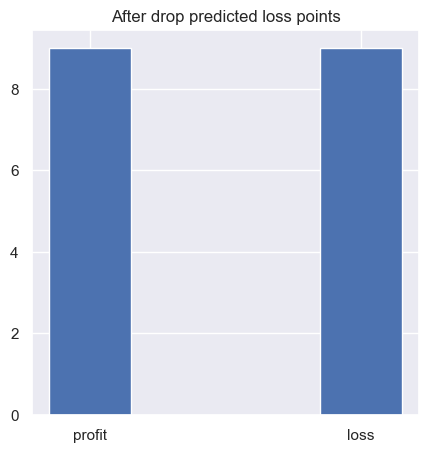

In [63]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.8

In [64]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
open_time,,
2025-06-01 01:00:00,0.710740,0.289260
2025-06-01 09:00:00,0.719866,0.280134
2025-06-01 14:00:00,0.701306,0.298694
2025-06-01 16:00:00,0.700114,0.299886
2025-06-01 18:00:00,0.757861,0.242139
...,...,...
2025-09-30 09:00:00,0.708224,0.291776
2025-09-30 15:00:00,0.716580,0.283420
2025-09-30 19:00:00,0.696772,0.303228


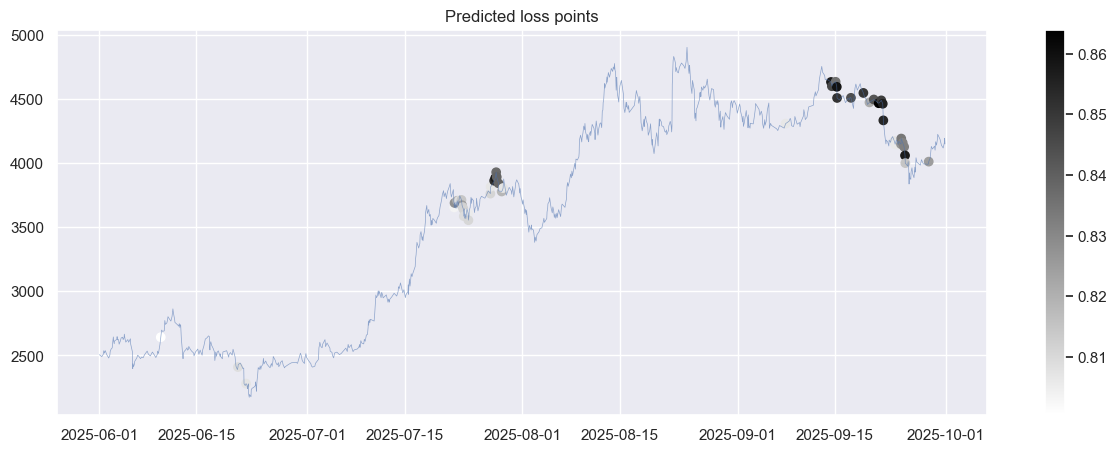

In [65]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.8]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [66]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.8].index)
predlabel2.value_counts()

y
-1.0    568
 1.0    248
Name: count, dtype: int64

In [67]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())

이익확률 pi:  0.696078431372549


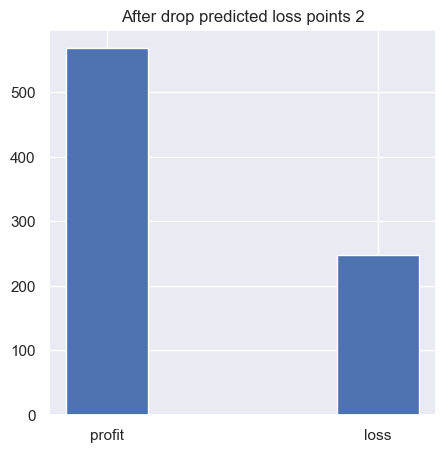

In [68]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [69]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>0.5].index)
finret

open_time
2025-07-07 14:00:00    0.017116
2025-07-09 19:00:00   -0.009646
2025-07-10 15:00:00    0.013807
2025-07-10 16:00:00    0.057025
2025-07-10 23:00:00   -0.008044
2025-07-11 08:00:00   -0.006602
2025-07-11 17:00:00   -0.006285
2025-07-11 20:00:00   -0.008283
2025-07-11 22:00:00   -0.007570
2025-08-04 02:00:00   -0.004213
2025-08-04 04:00:00    0.022748
2025-08-04 15:00:00    0.014075
2025-08-04 16:00:00   -0.004056
2025-08-04 20:00:00   -0.005279
2025-08-05 12:00:00   -0.014033
2025-08-05 17:00:00   -0.004988
2025-08-05 19:00:00    0.018595
2025-08-06 12:00:00    0.022012
2025-08-20 11:00:00   -0.014273
2025-08-20 13:00:00    0.028475
2025-08-20 15:00:00    0.025661
2025-08-20 16:00:00   -0.005651
2025-08-20 17:00:00   -0.012098
2025-08-20 18:00:00   -0.009774
2025-08-20 19:00:00   -0.005082
2025-08-21 08:00:00   -0.008500
2025-08-21 12:00:00   -0.006568
2025-08-21 15:00:00   -0.004938
2025-08-21 18:00:00   -0.008747
2025-08-21 19:00:00    0.015745
2025-08-22 01:00:00    0.01641

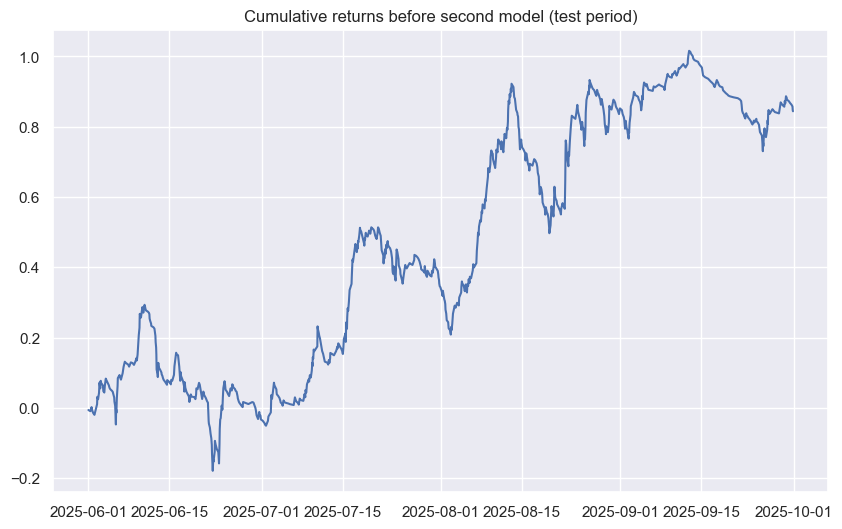

In [70]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

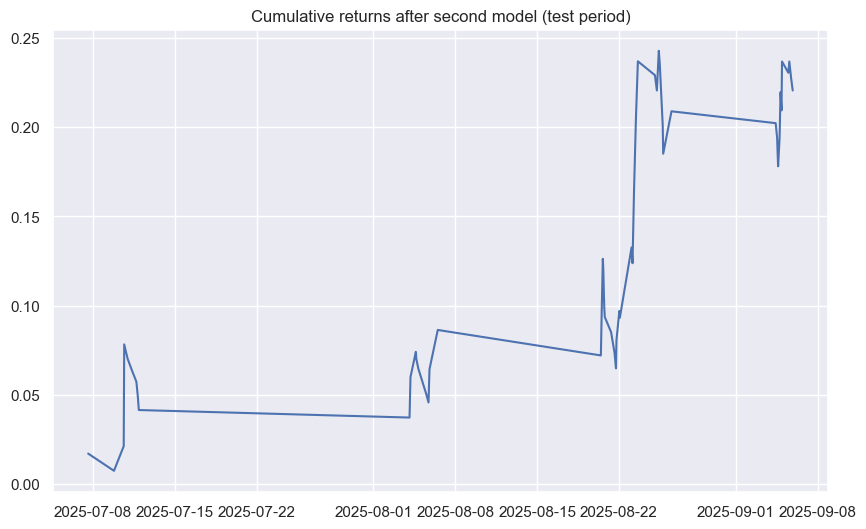

In [71]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### Trading

#### bet sizing

- Kelly rules (when betting data is normally dist.)
- Use predicted probabilities as bet confidence (suggested by DePrado)

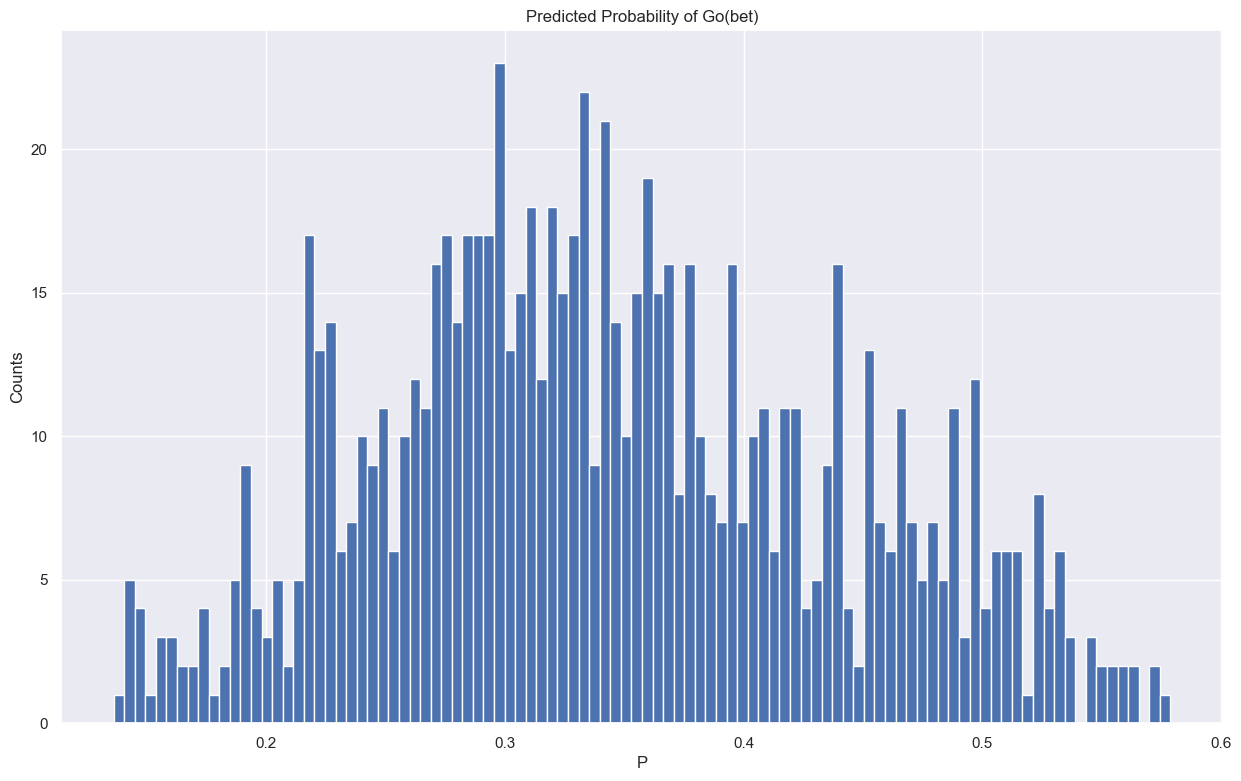

In [72]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

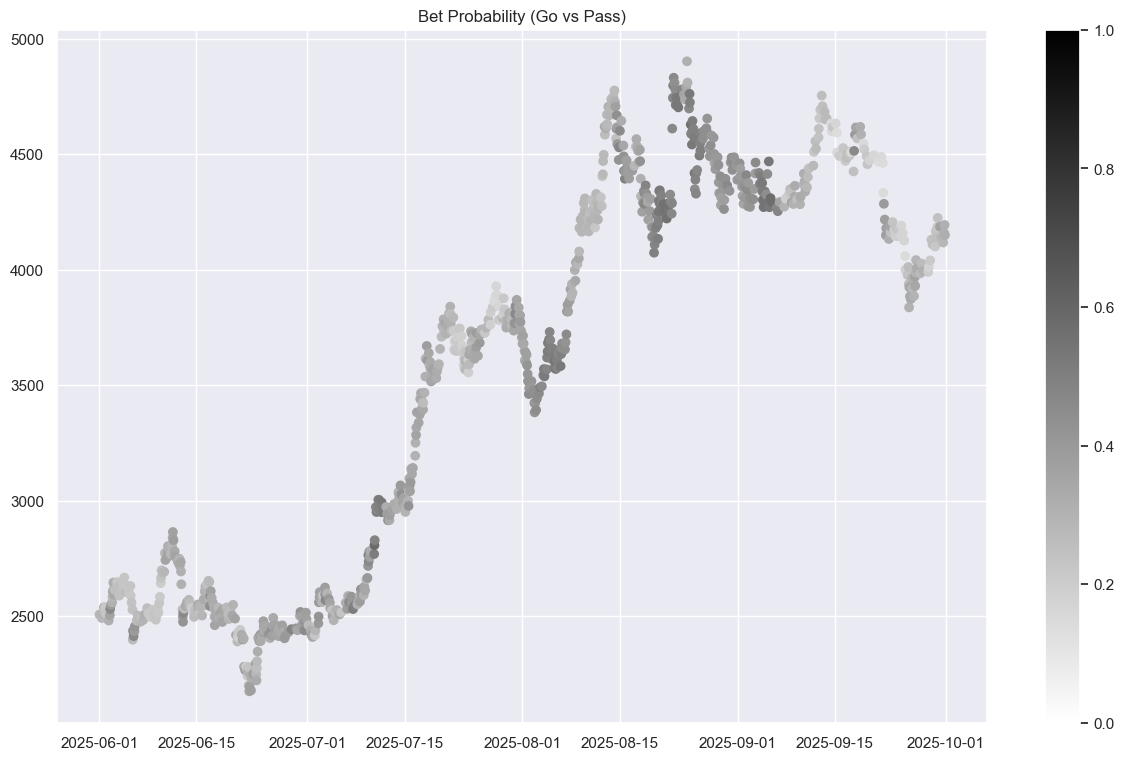

In [73]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

- not perfect yet

In [74]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [75]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [76]:
prob = p.copy()

m = get_signal(prob, 2)
# m
m = discretize(m, 0.25)

In [77]:
m

open_time
2025-06-01 01:00:00   -0.25
2025-06-01 09:00:00   -0.50
2025-06-01 14:00:00   -0.25
2025-06-01 16:00:00   -0.25
2025-06-01 18:00:00   -0.50
                       ... 
2025-09-30 09:00:00   -0.25
2025-09-30 15:00:00   -0.25
2025-09-30 19:00:00   -0.25
2025-09-30 20:00:00   -0.25
2025-09-30 21:00:00   -0.25
Name: 1.0, Length: 863, dtype: float64

In [78]:
# we only do long position betting

m.loc[m[m<0].index] = 0
m

open_time
2025-06-01 01:00:00    0.0
2025-06-01 09:00:00    0.0
2025-06-01 14:00:00    0.0
2025-06-01 16:00:00    0.0
2025-06-01 18:00:00    0.0
                      ... 
2025-09-30 09:00:00    0.0
2025-09-30 15:00:00    0.0
2025-09-30 19:00:00    0.0
2025-09-30 20:00:00    0.0
2025-09-30 21:00:00    0.0
Name: 1.0, Length: 863, dtype: float64

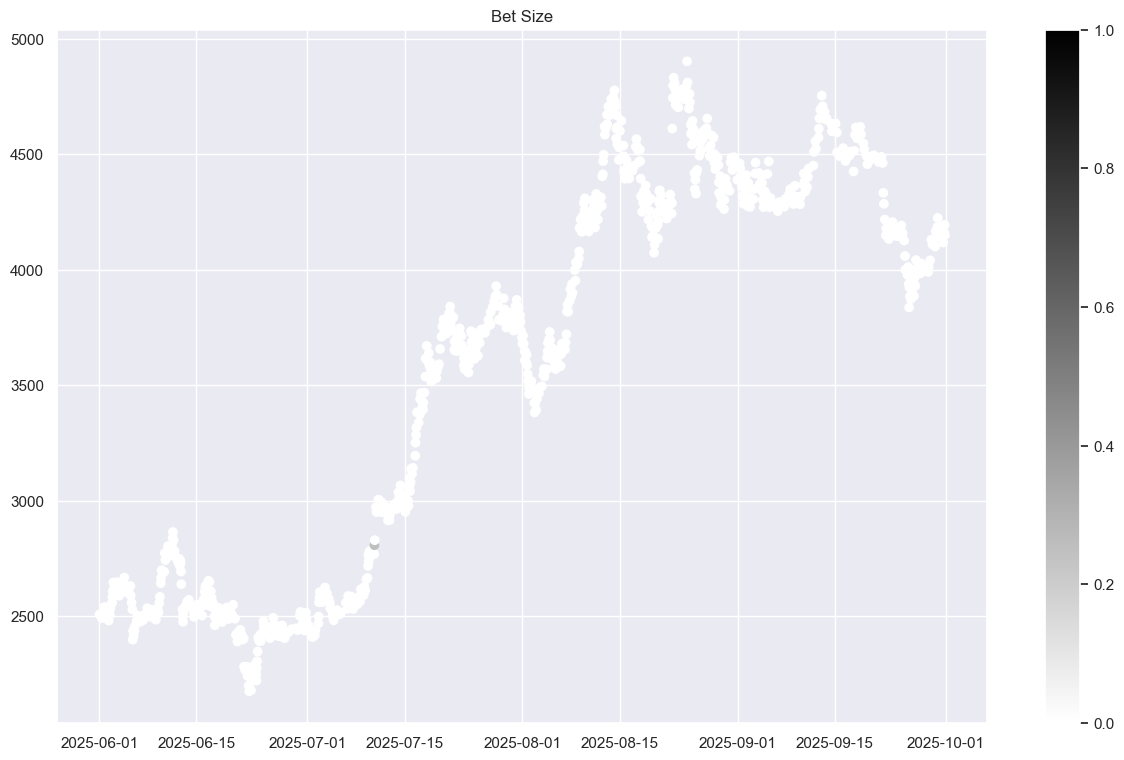

In [79]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [80]:
barrier_t = barrier.loc[y_true2.index]
barrier_t

,exit,price,side,ret
open_time,,,,
2025-06-01 01:00:00,2025-06-01 09:00:00,2506.51,1.0,-0.006127
2025-06-01 09:00:00,2025-06-01 12:00:00,2491.20,1.0,-0.003309
2025-06-01 14:00:00,2025-06-01 16:00:00,2508.21,1.0,0.011669
2025-06-01 16:00:00,2025-06-01 18:00:00,2537.65,1.0,-0.007440
2025-06-01 18:00:00,2025-06-02 02:00:00,2518.84,1.0,-0.004452
...,...,...,...,...
2025-09-30 09:00:00,2025-09-30 15:00:00,4139.25,1.0,-0.005125
2025-09-30 15:00:00,2025-09-30 16:00:00,4118.09,1.0,-0.004925
2025-09-30 19:00:00,2025-09-30 22:00:00,4158.48,1.0,-0.005017


In [81]:
initial_money=1
bet_size = m*initial_money
bet_size

open_time
2025-06-01 01:00:00    0.0
2025-06-01 09:00:00    0.0
2025-06-01 14:00:00    0.0
2025-06-01 16:00:00    0.0
2025-06-01 18:00:00    0.0
                      ... 
2025-09-30 09:00:00    0.0
2025-09-30 15:00:00    0.0
2025-09-30 19:00:00    0.0
2025-09-30 20:00:00    0.0
2025-09-30 21:00:00    0.0
Name: 1.0, Length: 863, dtype: float64

In [82]:
bet_size.index
# bet_size.columns()

barrier.index

DatetimeIndex(['2025-01-01 08:00:00', '2025-01-01 15:00:00',
               '2025-01-01 21:00:00', '2025-01-02 00:00:00',
               '2025-01-02 04:00:00', '2025-01-02 08:00:00',
               '2025-01-02 09:00:00', '2025-01-02 14:00:00',
               '2025-01-02 15:00:00', '2025-01-02 22:00:00',
               ...
               '2025-09-29 13:00:00', '2025-09-29 16:00:00',
               '2025-09-29 19:00:00', '2025-09-29 20:00:00',
               '2025-09-30 04:00:00', '2025-09-30 09:00:00',
               '2025-09-30 15:00:00', '2025-09-30 19:00:00',
               '2025-09-30 20:00:00', '2025-09-30 21:00:00'],
              dtype='datetime64[ns]', length=2152, freq=None)

In [83]:
wallet = tb.get_wallet_ratio_based_simple(close = close, barrier=barrier_t, bet_size = bet_size, max_pos=1, initial_money = 100000, fee_rate=0.0005, slippage=0.0001)
wallet

,cash_delta,pos_delta,cash_inventory,n_stock,price,total_equity,returns
open_time,,,,,,,
2025-01-01 00:00:00,0.0,0.0,100000.0000,0.0,3362.90,100000.0000,0.0
2025-01-01 01:00:00,0.0,0.0,100000.0000,0.0,3345.82,100000.0000,0.0
2025-01-01 02:00:00,0.0,0.0,100000.0000,0.0,3361.81,100000.0000,0.0
2025-01-01 03:00:00,0.0,0.0,100000.0000,0.0,3354.34,100000.0000,0.0
2025-01-01 04:00:00,0.0,0.0,100000.0000,0.0,3339.94,100000.0000,0.0
...,...,...,...,...,...,...,...
2025-09-30 19:00:00,0.0,0.0,101435.3157,0.0,4158.48,101435.3157,0.0
2025-09-30 20:00:00,0.0,0.0,101435.3157,0.0,4194.12,101435.3157,0.0
2025-09-30 21:00:00,0.0,0.0,101435.3157,0.0,4150.23,101435.3157,0.0


In [84]:
wallet.returns.cumsum()

open_time
2025-01-01 00:00:00    0.000000
2025-01-01 01:00:00    0.000000
2025-01-01 02:00:00    0.000000
2025-01-01 03:00:00    0.000000
2025-01-01 04:00:00    0.000000
                         ...   
2025-09-30 19:00:00    0.014346
2025-09-30 20:00:00    0.014346
2025-09-30 21:00:00    0.014346
2025-09-30 22:00:00    0.014346
2025-09-30 23:00:00    0.014346
Freq: h, Name: returns, Length: 6552, dtype: float64

In [85]:
cum_prod_return = (1 + wallet['returns']).cumprod() - 1
print(f"最终复利累计收益率: {cum_prod_return.iloc[-1]:.2%}")

最终复利累计收益率: 1.44%


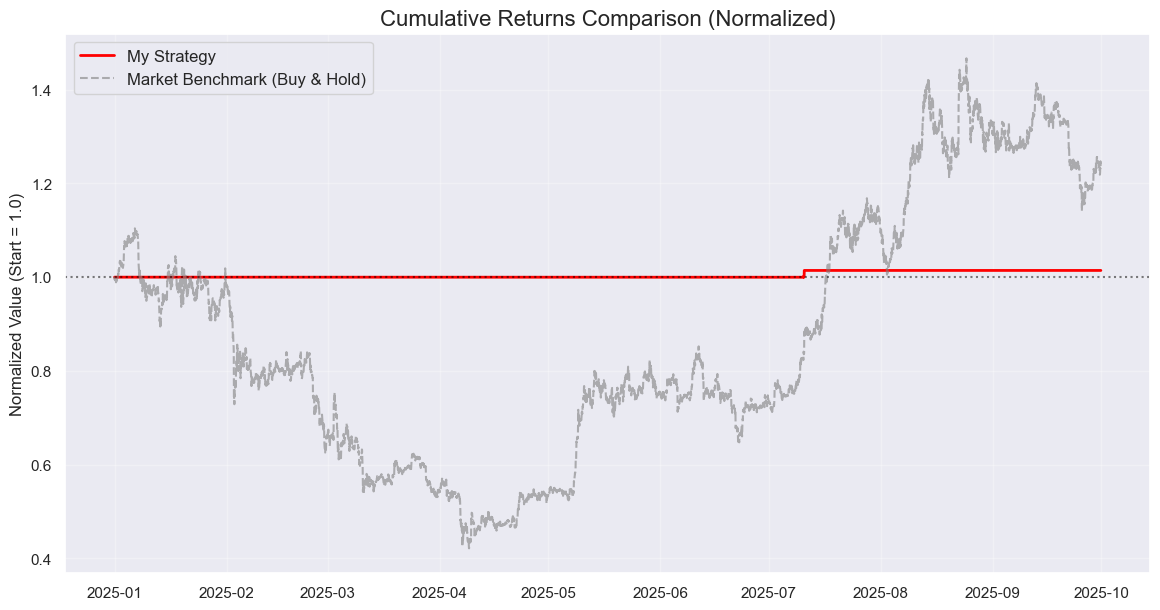

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# 1. 计算归一化净值 (从 1.0 开始)
# 策略净值 = 当前总资产 / 初始资金
strategy_curve = wallet['total_equity'] / wallet['total_equity'].iloc[0]

# 市场基准 = 当前价格 / 初始价格 (模拟全仓买入并持有)
market_curve = wallet['price'] / wallet['price'].iloc[0]

# 2. 绘图
plt.plot(strategy_curve.index, strategy_curve, label='My Strategy', color='red', linewidth=2)
plt.plot(market_curve.index, market_curve, label='Market Benchmark (Buy & Hold)', color='gray', alpha=0.6, linestyle='--')

# 3. 装饰
plt.axhline(y=1.0, color='black', linestyle=':', alpha=0.5) # 盈亏平衡线
plt.title('Cumulative Returns Comparison (Normalized)', fontsize=16)
plt.ylabel('Normalized Value (Start = 1.0)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.show()

- I made this function for only stocks. For cryptocurrency your buy amount or sell amount can be float.
- There is still error in bet sizing. This function calculate buy amount as *bet_size* * *initial_cash*. It should be *bet_size* * *cash_inventory*.

In [87]:
# eth_position = wallet.money_spent-wallet.money_receive
# cash_position = wallet.cash_inventory.diff()

In [88]:
# positions = pd.DataFrame()
# positions['ETH'] = eth_position
# positions['cash'] = cash_position
# positions

In [89]:
ret = barrier_t.ret
ret

open_time
2025-06-01 01:00:00   -0.006127
2025-06-01 09:00:00   -0.003309
2025-06-01 14:00:00    0.011669
2025-06-01 16:00:00   -0.007440
2025-06-01 18:00:00   -0.004452
                         ...   
2025-09-30 09:00:00   -0.005125
2025-09-30 15:00:00   -0.004925
2025-09-30 19:00:00   -0.005017
2025-09-30 20:00:00   -0.010520
2025-09-30 21:00:00   -0.003031
Name: ret, Length: 863, dtype: float64

In [90]:
# import pyfolio as pf

# # 在 Notebook 中这样操作：
# wallet = tb.get_wallet_v2(close, barrier_t, initial_money=10000)

# # 1. 计算每日收益率 (必须使用复利 prod，不能用 sum)
# # wallet['returns'] 已经是小数格式 (0.01 表示 1%)，不要再除以 100
# daily_ret = (1 + wallet['returns']).resample('D').prod() - 1

# # 2. 准备 Pyfolio 要求的 Positions DataFrame
# # 它必须包含各资产市值和 'cash' 列
# daily_pos = pd.DataFrame({
#     'ETH': wallet['n_stock'] * wallet['price'], # ETH 持仓市值
#     'cash': wallet['cash_inventory']            # 现金余额
# })

# # 3. 持仓重采样：取每日最后时刻的状态 (不能用 sum)
# daily_pos_resampled = daily_pos.resample('D').last()

# # 4. 调用 Pyfolio
# import pyfolio as pf
# pf.create_full_tear_sheet(
#     returns=daily_ret, 
#     positions=daily_pos_resampled
# )

In [91]:
# # 1. 将百分比收益率转换为小数
# ret_daily = ret.resample('D').sum()
# positions_daily = positions.resample('D').sum()

# ret_pyfolio = ret_daily / 100.0

# # 2. 规范化持仓数据 (可选，但建议检查)
# # 确保 positions_daily 的最后一列是 'cash'，且总和代表了组合的总价值
# # 如果您只想看收益率分析，可以暂时不传 positions 参数
# # pf.create_full_tear_sheet(ret_pyfolio) 

# # 3. 正确的调用方式
# import pyfolio as pf

# pf.create_full_tear_sheet(
#     returns=ret_pyfolio, 
#     positions=positions_daily # 确保这里的单位与组合总价值一致
#     # periods_per_year=365       # 针对加密货币市场
# )

# Further Study

Feature Analysis: 
    - How to efficiently extract information from various market features using deep learning.